In [1]:
USERNAME = 'OOIAPI-BI8MMX3Y14S4FL'
TOKEN = 'TEMP-TOKEN-MK0PEMRS0CFA8Z'

In [2]:
# First, we need to add some more Python libraries
import requests
import datetime
import time
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pickle as pk

In [3]:
import xarray as xr
import re
import requests
import os
import gc

In [4]:
# Instrument Information - Center Caldera BPR
site = 'RS03CCAL'
node = 'MJ03F'
instrument = '05-BOTPTA301'

VOCAB_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'

# Create the request URL (3 different ways)
# request_url = VOCAB_BASE_URL + '/'+site+'/'+ node+'/'+instrument # Good
# request_url = "%s/%s/%s/%s" % (VOCAB_BASE_URL,site,node,instrument) # Better
request_url ='/'.join((VOCAB_BASE_URL,site,node,instrument)) # Python wizard best

# Retrieve vocabulary information for a given instrument
r = requests.get(request_url, auth=(USERNAME, TOKEN))
data = r.json()

# data;

In [5]:
print(data)

[{'@class': '.VocabRecord', 'model': 'PMELcabled BPR/Tilt', 'manufacturer': 'PMEL/Chadwick', 'vocabId': 1451, 'refdes': 'RS03CCAL-MJ03F-05-BOTPTA301', 'instrument': 'Bottom Pressure and Tilt', 'tocL1': 'Cabled Axial Seamount', 'tocL2': 'Central Caldera', 'tocL3': 'Medium-Power JBox (MJ03F)', 'mindepth': 1526.0, 'maxdepth': 1526.0}]


In [6]:
# url='https://opendap.oceanobservatories.org/thredds/catalog/ooi/jazlynnatalie12@gmail.com/20180718T210007-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/catalog.html'
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/jazlynnatalie12@gmail.com/20190627T143904122Z-RS03ECAL-MJ03E-06-BOTPTA302-streamed-botpt_nano_sample/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]

In [7]:
# print(datasets)

In [8]:
# make the output directory
new_dir = '15s_mean_data/'
if not os.path.isdir(new_dir):
    try:
        os.makedirs(new_dir)
    except OSError:
        if os.path.exists(new_dir):
            pass
        else:
            raise

In [9]:
# Downsample data
# read in the data directly off THREDDS and write out as subsampled pickled pandas dataframe
# NOTE: It takes about one hour to subsample 69499.81 Mbytes of data and write it out to a dataframe. 
num = 0
for i in datasets:
    print('Downsampling file {} of {}'.format(str(num + 1), str(len(datasets))))
    ds = xr.open_dataset(i)
    ds = ds.swap_dims({'obs': 'time'})
    
    botpt = pd.DataFrame()
    botpt['bottom_pressure'] = ds['bottom_pressure'].to_pandas().resample('15S').mean()
    del botpt.index.name

    botpt = botpt.dropna()

    out = '15s_mean_data/' + i.split('/')[-1][:-3] + '_resampled' + '.pd'
    num = num +1

    with open(out, 'wb') as fh:
        pk.dump(botpt,fh)

    gc.collect()
print('Complete!')

Downsampling file 1 of 201


OSError: [Errno -45] NetCDF: Not a valid data type or _FillValue type mismatch: b'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/jazlynnatalie12@gmail.com/20190627T143904122Z-RS03ECAL-MJ03E-06-BOTPTA302-streamed-botpt_nano_sample/deployment0001_RS03ECAL-MJ03E-06-BOTPTA302-streamed-botpt_nano_sample_20190306T030000-20190311T150046.250000.nc'

In [ ]:
# Aggregate Downsample Data
# create a single file with all the pickled data.
botpt = pd.DataFrame()
for path, subdirs, files in os.walk('15s_mean_data/'):
#     files = files[1:]
    for name in files:
        file_name = os.path.join(path, name) 
        with open(file_name, 'rb') as f:
            pd_df = pk.load(f)
            botpt = botpt.append(pd_df)

botpt.index.name = 'time'
botpt = botpt.sort_values(by=['time'])

with open('botpt.pd', 'wb') as f:
    pk.dump(botpt,f)

In [ ]:
# to open the first file
x = xr.open_dataset(datasets[0])
print(x)

In [ ]:
# obtain more information on data variables (specify by adding .units, .comment, etc)
x['bottom_pressure'].time

NameError: name 'botpt' is not defined

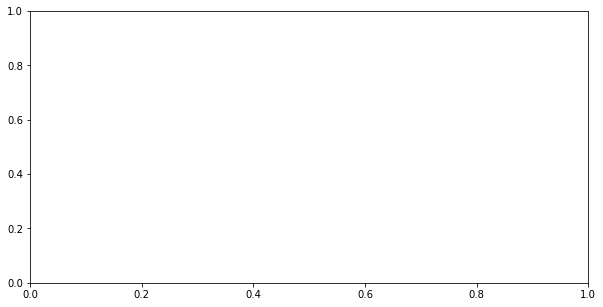

In [10]:
fig, (ax) = plt.subplots(figsize=(10,5))
botpt['bottom_pressure'].plot(axes=ax);
plt.ylabel('P (psia)', fontsize = 15, labelpad = 12)
plt.xlabel('time', fontsize = 15, labelpad = 12)
plt.title('BOTPT', fontsize = 15)
# fig.savefig('data_eval_plots/botpt.svg', format='svg', dpi=1200)

In [ ]:
# Import seismic data
seismic_file = '/home/jovyan/data/hypo71.dat.txt'
df_seismic_data = pd.read_csv(seismic_file, delim_whitespace=True, dtype=object)
df_seismic_data['datetime'] = df_seismic_data['yyyymmdd'] + 'T' + \
            df_seismic_data['HHMM'].str.slice(start=0, stop=2) + ':' + \
            df_seismic_data['HHMM'].str.slice(start=2) 
df_seismic_data.index = pd.to_datetime(df_seismic_data['datetime'].values)
df_seismic_data['datetime'] = pd.to_datetime(df_seismic_data['datetime'].values)
df_seismic_data = df_seismic_data.loc['2017-01-1 00:00:00':'2019-06-17 00:00:00']
df_seismic_data.head()
# del df_seismic_data['yyyymmdd']
# del df_seismic_data['HHMM']
del df_seismic_data['Lon(D']
# del df_seismic_data['SSS.SS']
# del df_seismic_data['Depth']
del df_seismic_data['M)']
del df_seismic_data['M).1']
del df_seismic_data['NWR']
del df_seismic_data['GAP']
del df_seismic_data['DMIN']
del df_seismic_data['ERH']
del df_seismic_data['ERZ']
del df_seismic_data['ID']
del df_seismic_data['Lat(D']
del df_seismic_data['PMom']
del df_seismic_data['SMom']
df_seismic_data['Depth'] = df_seismic_data['Depth'].astype('float64').values
df_seismic_data['MW'] = df_seismic_data['MW'].astype('float64').values
df_seismic_data['RMS'] = df_seismic_data['RMS'].astype('float64').values

In [ ]:
df_seismic_data.datetime.astype(np.int64).values/1e64
df_seismic_data['date'] =pd.DatetimeIndex(df_seismic_data.datetime).date
df_seismic_data.tail()

In [ ]:
df_seismic_data.plot(x='datetime', y= 'Depth')

In [ ]:
df_seismic_data.datetime.astype(np.int64).values/1e64
df_seismic_data['date'] =pd.DatetimeIndex(df_seismic_data.datetime).date
df_seismic_data.tail()

In [ ]:
# Create dataframe with earthquake frequency
df_eqMean=df_seismic_data.groupby('date').mean()
df_eqCount= df_seismic_data.groupby('date').count()
#del df_eqMean['datetime']
#df_eqMean.columns.name = df_eqMean.index.name
#df_eqMean.index.name = None
df_eqMean.tail()

In [ ]:
df_eqCount['count'] = df_eqCount.datetime.astype('float64').values
df_eqCount.head()

In [ ]:
df_eqMean['count'] = df_eqCount['count'].values
df_eqMean.head()

In [ ]:
# Add days to earthquake data where there were zero earthquakes
idx = pd.date_range('2017-01-1 00:00:00', '2019-06-16 00:00:00')

df_eqMean = df_eqMean

df_eqMean.index = pd.DatetimeIndex(df_eqMean.index)

df_eqMean = df_eqMean.reindex(idx, fill_value=0)
df_eqMean.tail()

In [ ]:
import hvplot.pandas
a= df_eqMean.hvplot.scatter(y= 'count')
b= df_eqMean.hvplot.scatter(y= 'Depth')
a+b

#### Create time and count vectors earthquake frequency vectors for plotting 

In [ ]:
count = df_eqMean['count'].tolist()
time_int = []
time = list(pd.to_datetime(df_eqMean.index.values))
for i in time:
    i = np.datetime64(i).astype(datetime.datetime)
    time_int.append(dates.date2num(i))

In [ ]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [ ]:
# smooth data using rolling window that chops off 95th percentile 
count_av = list(movingaverage(df_eqMean['count'],21))

In [ ]:
plt.close()
fig4, (ax1,ax2) = plt.subplots(2,1)
fig4.set_size_inches(30, 14)
hb1 = ax1.plot(cleaner_time, cleaner_data, linewidth=5)
ax1.yaxis.grid(True)
ax1.xaxis.grid(True)
ax1.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
#years = dates.YearLocator()
months = dates.MonthLocator()
#yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)
#ax1.xaxis.set_minor_locator(years)
#ax1.xaxis.set_minor_formatter(yearsFmt)
ax1.set_title('Caldera Inflation', fontsize=36, fontweight = 'bold')
ax1.set_ylabel('Depth-Diff (m)', fontsize=36, fontweight = 'bold', rotation=90)


hb1 = ax2.plot(time, count)
hb2 = ax2.plot(time, count_av, linewidth=5)
ax2.yaxis.grid(True)
ax2.xaxis.grid(True)
ax2.set_xlim(datetime.datetime(2017, 1, 1, 0, 0),datetime.datetime(2019, 6, 17, 0, 0))
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthsFmt)
ax2.xaxis.set_minor_locator(years)
ax2.xaxis.set_minor_formatter(yearsFmt)
ax2.set_title('Daily Seismicity', fontsize=36, fontweight = 'bold')
ax2.set_ylabel('EQ/Day', fontsize=36, fontweight = 'bold', rotation=90)

#plt.tight_layout()
plt.setp(ax1.set_xticklabels([]))
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0, fontsize=24)
#plt.setp(ax1.xaxis.get_minorticklabels(), rotation=0, fontsize=24)
plt.setp(ax1.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')

plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')
plt.setp(ax2.xaxis.get_minorticklabels(), rotation=0, fontsize=36, fontweight = 'bold')
plt.setp(ax2.yaxis.get_majorticklabels(), rotation=0, fontsize=24, fontweight = 'bold')

#plt.suptitle('Comparison Between Inflation and Seismicity',
#             fontsize=32, color= 'blue', fontweight = 'bold')
plt.subplots_adjust(top=0.90, hspace=0.25)
plt.savefig('/home/jovyan/AGU_2018/Examples/botptvseq.png')